In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

<AxesSubplot:xlabel='Date'>

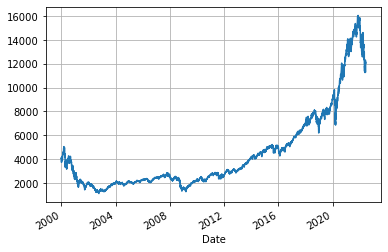

In [2]:
start = (2000, 1, 1)  # 2020년 01년 01월 
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# yahoo 에서 나스닥 불러오기 
df = pdr.DataReader('^IXIC', 'yahoo', start, end)
df.Close.plot(grid=True)

In [3]:
X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

                    High           Low          Open         Close  \
Date                                                                 
1999-12-31   4082.370117   4032.330078   4056.989990   4069.310059   
2000-01-03   4192.189941   3989.709961   4186.189941   4131.149902   
2000-01-04   4073.250000   3898.229980   4020.000000   3901.689941   
2000-01-05   3924.209961   3734.870117   3854.350098   3877.540039   
2000-01-06   3868.760010   3715.620117   3834.439941   3727.129883   
...                  ...           ...           ...           ...   
2022-06-06  12245.400391  12004.200195  12200.330078  12061.370117   
2022-06-07  12194.860352  11888.610352  11925.809570  12175.230469   
2022-06-08  12235.780273  12052.700195  12147.280273  12086.269531   
2022-06-09  12115.059570  11751.980469  12016.469727  11754.230469   
2022-06-10  11569.150391  11328.269531  11543.879883  11340.019531   

               Adj Close  
Date                      
1999-12-31   4069.310059  
2000-01-

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test Data 
"""
( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
"""
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4500, 5) (4500, 1)
Testing Shape (1148, 5) (1148, 1)


In [5]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1148, 1, 5]) torch.Size([1148, 1])


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
#print(torch.cuda.get_device_name(0))

In [7]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [19]:
num_epochs = 30000#1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer


for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.01993
Epoch: 100, loss: 0.01509
Epoch: 200, loss: 0.01186
Epoch: 300, loss: 0.00985
Epoch: 400, loss: 0.00868
Epoch: 500, loss: 0.00806
Epoch: 600, loss: 0.00776
Epoch: 700, loss: 0.00762
Epoch: 800, loss: 0.00755
Epoch: 900, loss: 0.00750
Epoch: 1000, loss: 0.00747
Epoch: 1100, loss: 0.00744
Epoch: 1200, loss: 0.00741
Epoch: 1300, loss: 0.00738
Epoch: 1400, loss: 0.00735
Epoch: 1500, loss: 0.00731
Epoch: 1600, loss: 0.00728
Epoch: 1700, loss: 0.00724
Epoch: 1800, loss: 0.00720
Epoch: 1900, loss: 0.00716
Epoch: 2000, loss: 0.00711
Epoch: 2100, loss: 0.00707
Epoch: 2200, loss: 0.00702
Epoch: 2300, loss: 0.00696
Epoch: 2400, loss: 0.00691
Epoch: 2500, loss: 0.00685
Epoch: 2600, loss: 0.00679
Epoch: 2700, loss: 0.00673
Epoch: 2800, loss: 0.00666
Epoch: 2900, loss: 0.00659
Epoch: 3000, loss: 0.00652
Epoch: 3100, loss: 0.00644
Epoch: 3200, loss: 0.00636
Epoch: 3300, loss: 0.00628
Epoch: 3400, loss: 0.00619
Epoch: 3500, loss: 0.00610
Epoch: 3600, loss: 0.00601
Epoch: 3700, 

Epoch: 29700, loss: 0.00000
Epoch: 29800, loss: 0.00000
Epoch: 29900, loss: 0.00000


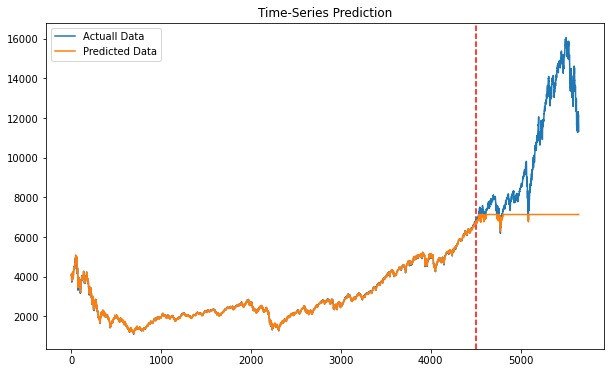

In [21]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()

plt.show() 

# TA 코드

<AxesSubplot:xlabel='Date'>

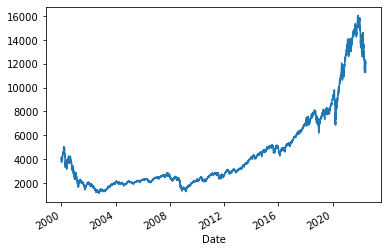

In [10]:
train_df = df
train_df.Close.plot()
# Get the numpy array
#train_data = train_df.iloc[:, 1:2].values

In [11]:
train_data = train_df.iloc[:, 5:6].values

In [12]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

In [13]:
sc = MinMaxScaler()
train_data = sc.fit_transform(train_data)
seq_length = 4
x, y = sliding_windows(train_data, seq_length)
train_len = int(len(y) * 0.9)
valid_len = len(y) - train_len
x_tensor = torch.tensor(x, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)
train_x = x_tensor[:train_len]
train_y = y_tensor[:train_len]
valid_x = x_tensor[train_len:]
valid_y = y_tensor[train_len:]

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_features, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_features = num_features
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
        num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_features)
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size) # (batch_size * num_layers, hidden_size)
        out = self.fc(h_out)
        return out

In [15]:
num_epochs = 2000
learning_rate = 0.01
input_size = 1
hidden_size = 2
num_layers = 1
num_features = 1
lstm = LSTM(num_features, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [16]:
for epoch in range(num_epochs):
    outputs = lstm(train_x)
    #print(outputs)
    # obtain the loss function
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.detach().item()))

Epoch: 0, loss: 0.16672
Epoch: 100, loss: 0.01011
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00007
Epoch: 400, loss: 0.00007
Epoch: 500, loss: 0.00006
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00004
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00003
Epoch: 1200, loss: 0.00003
Epoch: 1300, loss: 0.00003
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002


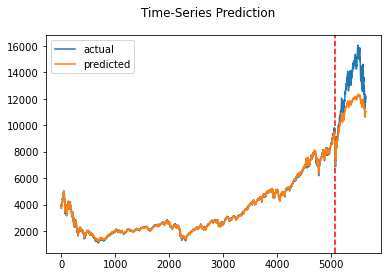

In [17]:
lstm.eval()
with torch.no_grad():
    train_predict = lstm(x_tensor)
pred_y = train_predict.detach().numpy()
act_y = y_tensor.detach().numpy()
pred_y = sc.inverse_transform(pred_y)
act_y = sc.inverse_transform(act_y)
plt.axvline(x=train_len, c='r', linestyle='--')
plt.plot(act_y, label='actual')
plt.plot(pred_y, label='predicted')
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [18]:
volume = train_df.iloc[:,4:5]

volume

,Volume
Date,
1999-12-31,762980000
2000-01-03,1510070000
2000-01-04,1511840000
2000-01-05,1735670000
2000-01-06,1598320000
...,...
2022-06-06,4633950000
2022-06-07,4383960000
2022-06-08,4689310000
